<a href="https://colab.research.google.com/github/shyuwang/Time-Series-Forecasting/blob/main/Time-Series-Forecasting/store-item-demand-forecasting/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [1]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f1c661a18dc00cdc3da15cf46ae42e4172bf2e525b4799682bc505fbbec9630a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


Check if pyspark is installed successfully.

In [2]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
spark

In [3]:
# Path of training set on Google drive
train_path = '/content/drive/MyDrive/demand-forecasting-at-scale-data/train.csv'

# Loading data

In [6]:
from pyspark.sql.types import *
 
# Structure of the training data set
train_schema = StructType([
  StructField('Date', DateType()),
  StructField('Store', IntegerType()),
  StructField('Item', IntegerType()),
  StructField('Sales', IntegerType())
  ])
 
# Read the training file into a dataframe
train = spark.read.csv(
  train_path, 
  header=True, 
  schema=train_schema
  )

In [7]:
train.createOrReplaceTempView('train')
 
# Show data
train.show(5)

+----------+-----+----+-----+
|      Date|Store|Item|Sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
+----------+-----+----+-----+
only showing top 5 rows



# EDA

## Coverage examination

In [8]:
query = """
  select
    year(Date) as year
    ,count(distinct Store) as Num_Stores
    ,count(distinct Item) as Num_Items
    ,count(distinct Date) as Num_Days
  from train
  group by 1
  order by 1
"""

spark.sql(query).show()

+----+----------+---------+--------+
|year|Num_Stores|Num_Items|Num_Days|
+----+----------+---------+--------+
|2013|        10|       50|     365|
|2014|        10|       50|     365|
|2015|        10|       50|     365|
|2016|        10|       50|     366|
|2017|        10|       50|     365|
+----+----------+---------+--------+



The training dataset is quite clean that it contains 5-year data of store-item unit sales data for 50 items across 10 stores. No day or store closure. Therefore, it's reasonable to compare total sales in the following analysis.

(The data is available on Kaggle: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data)

## Yearly trend
General trend

In [21]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt

In [12]:
query = """
  select
    year(Date) as Year
    ,sum(Sales) as Sales
  from train
  group by 1
  order by 1
"""
df = spark.sql(query)
df.show()

+----+--------+
|Year|   Sales|
+----+--------+
|2013| 7941243|
|2014| 9135482|
|2015| 9536887|
|2016|10357160|
|2017|10733740|
+----+--------+



In [20]:
# Pandas API on Spark
psdf = df.pandas_api()
psdf.plot.line(x='Year', y='Sales') 

There exists an increasing trend of yearly sales. Without knowing detailed information of the market (e.g., if there is a maximum capacity of the total sales per year), we could assume that the upward trend would continue over the time we forecast.

## Monthly trend
Seasonality

In [22]:
# Agg over all years
query = """
  select
    month(Date) as Month
    ,sum(Sales) as Sales
  from train
  group by 1
  order by 1
"""
df = spark.sql(query)
df.show()

+-----+-------+
|Month|  Sales|
+-----+-------+
|    1|2753149|
|    2|2776177|
|    3|3666182|
|    4|4136467|
|    5|4582437|
|    6|4726911|
|    7|5192393|
|    8|4580655|
|    9|4130457|
|   10|3967520|
|   11|4141356|
|   12|3050808|
+-----+-------+



In [23]:
psdf = df.pandas_api()
psdf.plot.line(x='Month',y='Sales')

In [26]:
# Year+Month
query = """
  select
    trunc(date, 'MM') as Month
    ,sum(Sales) as Sales
  from train
  group by 1
  order by 1
"""
df = spark.sql(query)
df.show()

+----------+------+
|     Month| Sales|
+----------+------+
|2013-01-01|454904|
|2013-02-01|459417|
|2013-03-01|617382|
|2013-04-01|682274|
|2013-05-01|763242|
|2013-06-01|795597|
|2013-07-01|855922|
|2013-08-01|766761|
|2013-09-01|689907|
|2013-10-01|656587|
|2013-11-01|692643|
|2013-12-01|506607|
|2014-01-01|525987|
|2014-02-01|529117|
|2014-03-01|704301|
|2014-04-01|788914|
|2014-05-01|882877|
|2014-06-01|906842|
|2014-07-01|989010|
|2014-08-01|885596|
+----------+------+
only showing top 20 rows



In [27]:
psdf = df.pandas_api()
psdf.plot.line(x='Month',y='Sales')

July is the peak. Sales climb from Jan to July, then drop when approaching Dec.

## Weekday trends

In [37]:
query = """
select 
  Year(Date) as Year
  ,case when date_format(Date, 'EEEE') = 'Monday' then 1
        when date_format(Date, 'EEEE') = 'Tuesday' then 2
        when date_format(Date, 'EEEE') = 'Wednesday' then 3
        when date_format(Date, 'EEEE') = 'Thursday' then 4
        when date_format(Date, 'EEEE') = 'Friday' then 5
        when date_format(Date, 'EEEE') = 'Saturday' then 6
        when date_format(Date, 'EEEE') = 'Sunday' then 7 end as DayOfWeek
  ,sum(Sales) as Sales
from train
group by 1,2
order by 1,2
"""

df = spark.sql(query)
df .show()

+----+---------+-------+
|Year|DayOfWeek|  Sales|
+----+---------+-------+
|2013|        1| 898024|
|2013|        2|1060838|
|2013|        3|1047808|
|2013|        4|1118166|
|2013|        5|1199697|
|2013|        6|1275711|
|2013|        7|1340999|
|2014|        1|1029183|
|2014|        2|1205326|
|2014|        3|1219502|
|2014|        4|1289906|
|2014|        5|1369927|
|2014|        6|1466786|
|2014|        7|1554852|
|2015|        1|1080971|
|2015|        2|1252678|
|2015|        3|1257066|
|2015|        4|1365475|
|2015|        5|1437323|
|2015|        6|1520251|
+----+---------+-------+
only showing top 20 rows



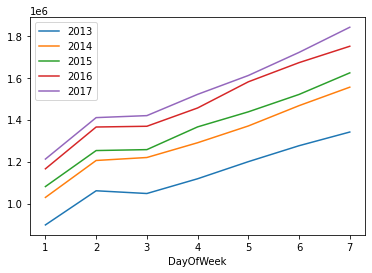

In [46]:
# Convert to pandas dataframe
pdf = df.toPandas()

# Define index column
pdf.set_index('DayOfWeek', inplace=True)

# Group data by year and display sales as line chart
pdf.groupby('Year')['Sales'].plot(legend=True)

plt.show()

A weekly pattern is observed with a peak on Sunday, and a steady upward trend from Monday to Sunday. The same pattern across 5 years.